In [7]:
import random
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
random.seed(42)

import albumentations as A
import cv2
import numpy as np
import torch
from tqdm.auto import tqdm

from src.data import IDAOData, train_transforms

In [53]:
from src.data import CENTER, NORM_MEAN, NORM_STD

## Load data

In [2]:
# New directories
data_root = Path("data")

train_dir = data_root / "train"
val_dir = data_root / "val"
test_dir = data_root / "test"
test_holdout_dir = data_root / "test_holdout"

# Check new datasets
train_ds = IDAOData(train_dir, transform=train_transforms())
val_ds = IDAOData(val_dir)
test_ds = IDAOData(test_dir)
test_holdout_ds = IDAOData(test_holdout_dir)

In [58]:
Counter(train_ds.classes)

Counter({('ER', 30): 2017,
         ('NR', 1): 1963,
         ('NR', 6): 2017,
         ('NR', 20): 1986,
         ('ER', 10): 2057,
         ('ER', 3): 2015})

In [59]:
Counter(val_ds.classes)

Counter({('ER', 10): 105,
         ('ER', 30): 109,
         ('ER', 3): 106,
         ('NR', 1): 116,
         ('NR', 6): 105,
         ('NR', 20): 115})

In [60]:
Counter(test_ds.classes)

Counter({('NR', 20): 107,
         ('ER', 3): 122,
         ('NR', 6): 133,
         ('ER', 30): 111,
         ('ER', 10): 110,
         ('NR', 1): 98})

In [61]:
Counter(test_holdout_ds.classes)

Counter({('ER', 1): 3,
         ('NR', 10): 2,
         ('NR', 3): 2,
         ('ER', 6): 1,
         ('NR', 30): 2,
         ('ER', 20): 2})

## Test some images - classes + denoising

Let's check for each class what the images look like

In [92]:
full_dataset = train_ds

In [93]:
e1 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 1]
e3 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 3]
e6 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 6]
e10 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 10]
e20 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 20]
e30 = [idx for idx, icls in enumerate(full_dataset.classes) if icls[1] == 30]
ER = [idx for idx, icls in enumerate(full_dataset.classes) if icls[0] == 'ER']
NR = [idx for idx, icls in enumerate(full_dataset.classes) if icls[0] == 'NR']

indices = [e1, e3, e6, e10, e20, e30]
titles = [f'Energy {i}' for i in (1, 3, 6, 10, 20, 30)]

In [63]:
def get_avg_value_and_distance(img_yx):
    assert img_yx.shape[0] == img_yx.shape[1]
    img_yx = img_yx.copy()
    img_yx[img_yx < 0] = 0
    
    coor_y = 0.5 + np.arange(img_yx.shape[0])

    def get_offset_and_var(axis):
        """pass axis=1 to get stats for y and axis=0 for x"""
        # assuming axis == 1
        p_y = img_yx.sum(axis)
        p_y /= p_y.sum()
        avg_y = (p_y * coor_y).sum()
        var_y = (p_y * (coor_y - avg_y)**2).sum()
        offset_y = avg_y - coor_y.size / 2
        return offset_y, var_y
    
    offset_x, var_x = get_offset_and_var(0)
    offset_y, var_y = get_offset_and_var(1)


    return img_yx.sum(), offset_x, offset_y, offset_x**2 + offset_x**2, var_x + var_y

def normalize(img):
    return (img / 255 - NORM_MEAN) / NORM_STD

def denormalize(img):
    return (255 * (NORM_STD * img + NORM_MEAN)).astype(int)

In [82]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise


def plot_denoised(img):
    original = denormalize(img) # img_as_float(data.chelsea()[100:250, 50:300])

    # sigma = 0.155
    noisy = original # random_noise(original, var=sigma**2)

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),
                           sharex=True, sharey=True)

    plt.gray()

    # Estimate the average noise standard deviation across color channels.
    sigma_est = estimate_sigma(noisy, multichannel=False, average_sigmas=True)
    # Due to clipping in random_noise, the estimate will be a bit smaller than the
    # specified sigma.
    print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

    ax[0, 0].imshow(noisy)
    ax[0, 0].axis('off')
    ax[0, 0].set_title('Noisy Original')
    ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.05, n_iter_max=10, multichannel=False))
    ax[0, 1].axis('off')
    ax[0, 1].set_title('TV')
    ax[0, 2].imshow(denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15,
                    multichannel=False))
    ax[0, 2].axis('off')
    ax[0, 2].set_title('Bilateral')
    ax[0, 3].imshow(denoise_wavelet(noisy, multichannel=False, rescale_sigma=True))
    ax[0, 3].axis('off')
    ax[0, 3].set_title('Wavelet denoising')

    ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.7, multichannel=False))
    ax[1, 1].axis('off')
    ax[1, 1].set_title('(more) TV')
    ax[1, 2].imshow(denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=1,
                    multichannel=False))
    ax[1, 2].axis('off')
    ax[1, 2].set_title('(more) Bilateral')
    # ax[1, 3].imshow(denoise_wavelet(noisy, multichannel=False, convert2ycbcr=True,
    #                                 rescale_sigma=True))
    ax[1, 3].axis('off')
    ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
    ax[1, 0].imshow(original)
    ax[1, 0].axis('off')
    ax[1, 0].set_title('Noisy Original')

    fig.tight_layout()

    plt.show()

### Inspect how denoising works

1 1


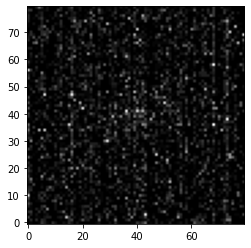

(235.77403921568663, -0.5642304357656229, 0.505357406010873, 0.6367119692885295, 1006.5118962893484)
Estimated Gaussian noise standard deviation = 1.8581230179395056


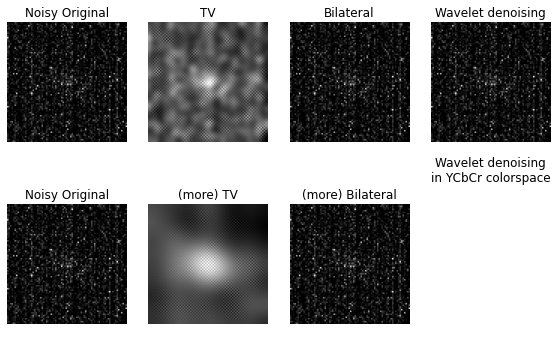

0 10


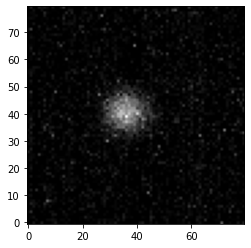

(348.23568627451016, -0.6410583246340167, 0.446445405654579, 0.8219115511651447, 661.8795550599712)
Estimated Gaussian noise standard deviation = 1.7969421366091736


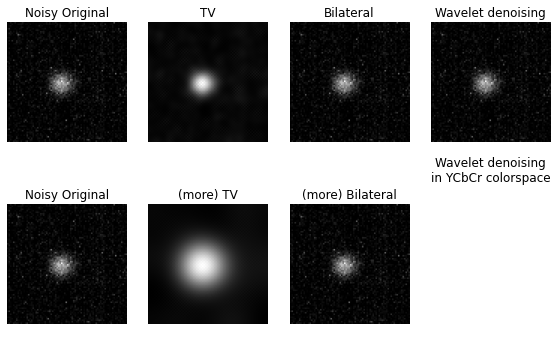

1 20


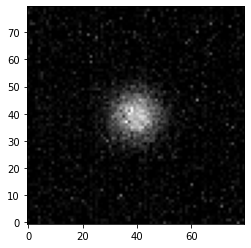

(471.2763660130723, -0.27217242497789584, -0.26018073793315466, 0.14815565783669668, 555.3097042767456)
Estimated Gaussian noise standard deviation = 2.0434482952527033


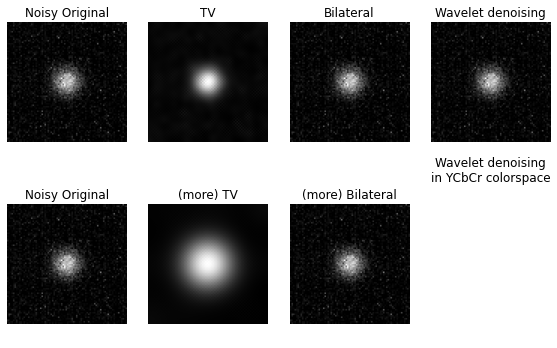

In [83]:
# i = -13
i = 102
# i = 103

for i in range(100, 103):

    tmp_img_yx, tmp_r_type, tmp_energy = val_ds[i]
    print(tmp_r_type, tmp_energy)

    tmp_img_yx = normalize(tmp_img_yx[0].copy())
    tmp_img_yx[tmp_img_yx < 0] = 0

    center = tmp_img_yx.shape[0] // 2
    offset = 40
    slc = slice(center - offset, center + offset)

    tmp_img_yx = tmp_img_yx[slc, slc]


    plt.imshow((tmp_img_yx).astype(float), origin='lower')
    plt.show()

    print(get_avg_value_and_distance(tmp_img_yx))
    plot_denoised(tmp_img_yx)

In [94]:
# # couldn't make it work
# import numpy as np
# import cv2
# from matplotlib import pyplot as plt
# # cv2.fastNlMeansDenoising() 

# raw_tmp_img_yx = denormalize(tmp_img_yx)

# kernel = np.ones((3,3),np.float32)/9
# dst = cv2.filter2D(raw_tmp_img_yx[None, ...],-1,kernel)

# raw_tmp_img_yx[raw_tmp_img_yx < 100] = 100
# dst[dst < 104] = 100

# plt.subplot(121)
# plt.imshow(raw_tmp_img_yx)
# plt.subplot(122)
# plt.imshow(dst)
# plt.show()

### Estimate center of mass and variance

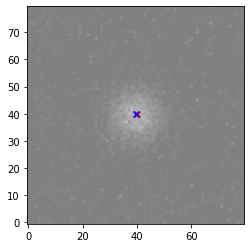

In [90]:
fig, ax = plt.subplots(1, 1)
num_points, x, y, sq_dist, sq_var = get_avg_value_and_distance(tmp_img_yx)
ax.imshow(tmp_img_yx, vmin=-3, vmax=3, origin='lower')
ax.scatter([offset], [offset], c='r', marker='x', )
ax.scatter([offset + x], [offset + y], c='b', marker='x', )

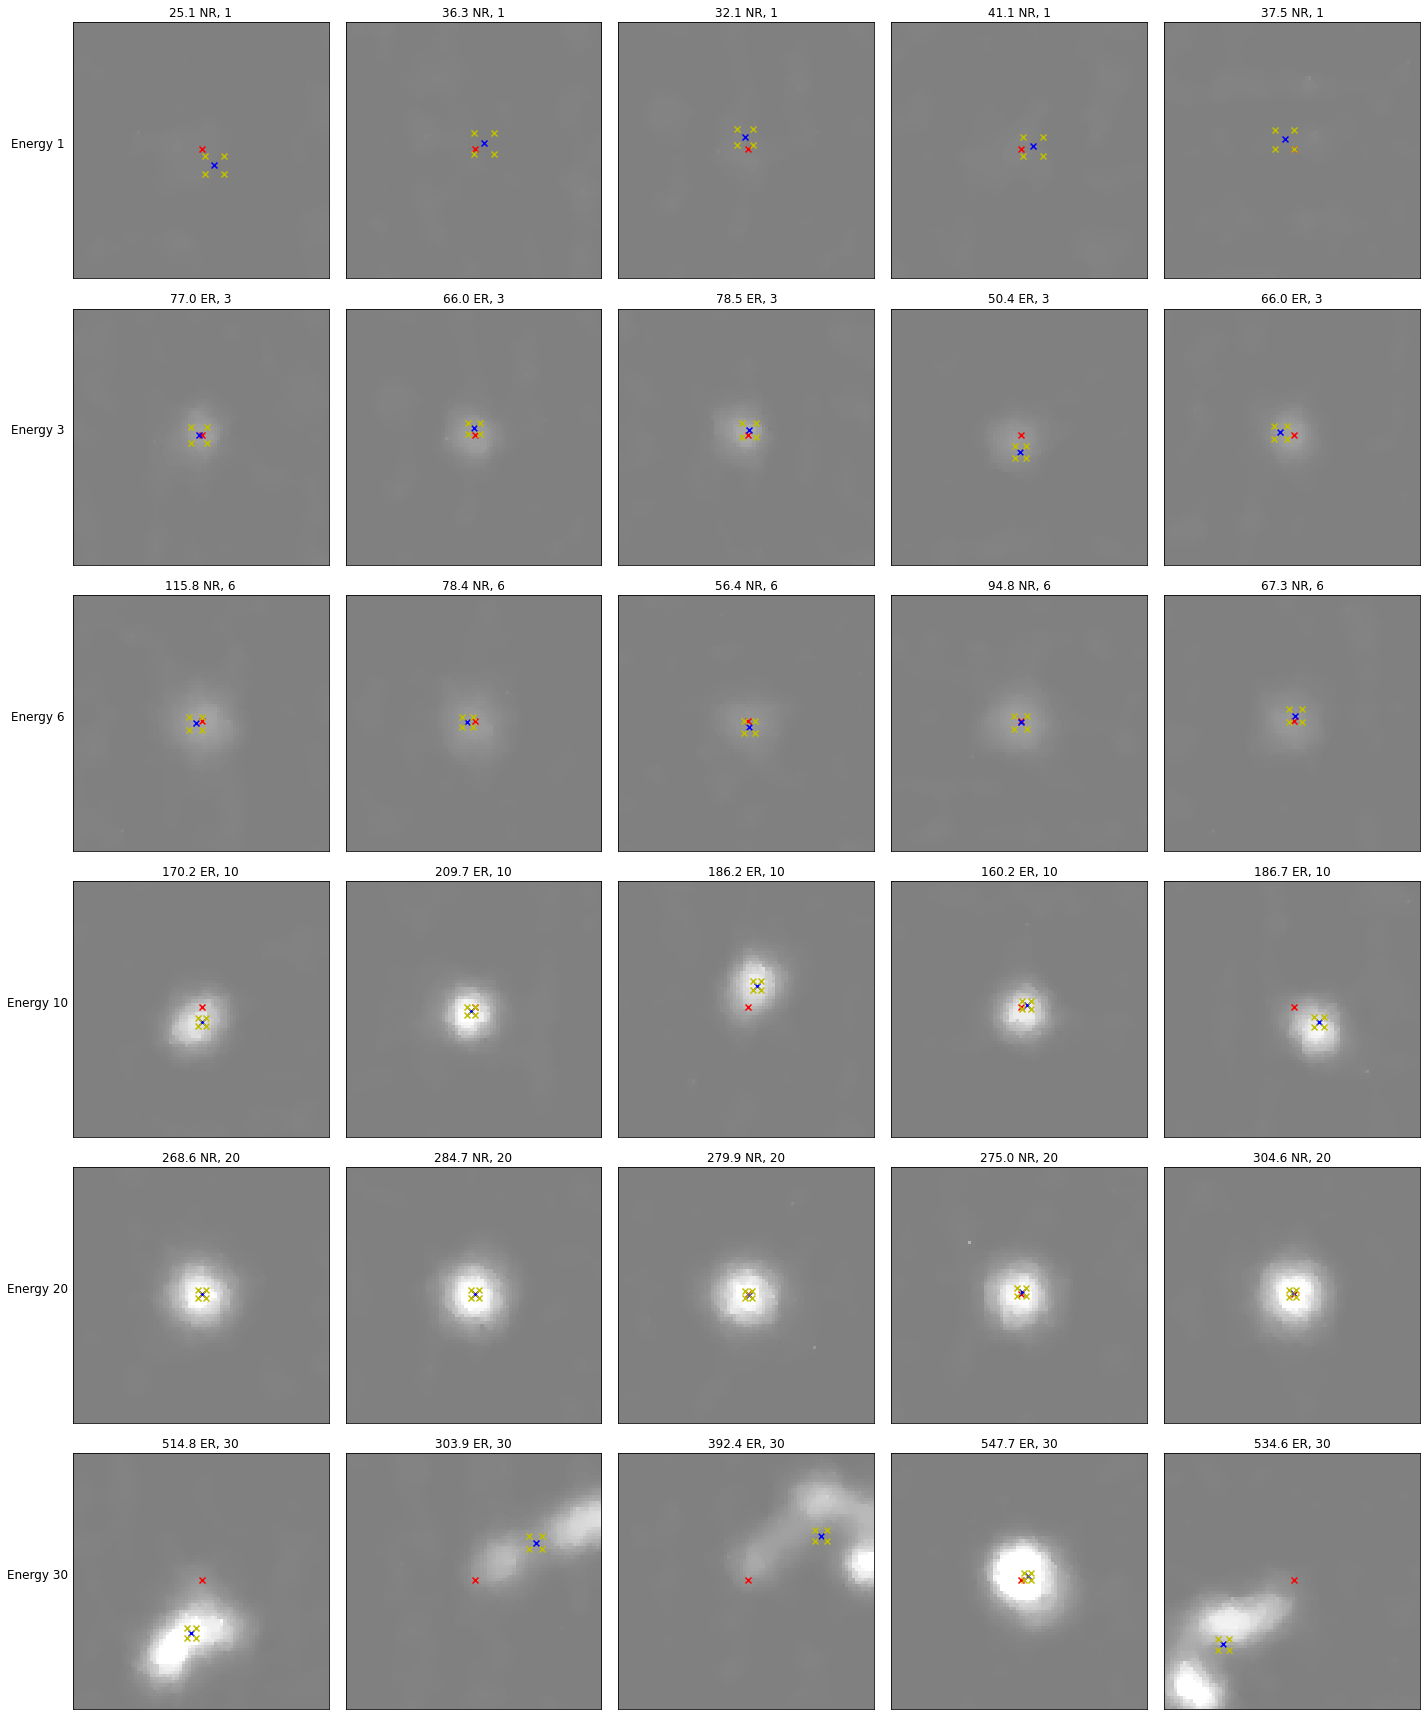

In [97]:
N = 5
fig, axes = plt.subplots(len(titles), N, figsize = (N*4, len(titles)*4))

inds = np.arange(1000)
for idx, (inds, title) in enumerate(zip(indices, titles)):
    axes[idx, 0].set_ylabel(title, rotation=0, size='large', labelpad=35)
    for j in range(N):
        ax = axes[idx, j]
        img, r_type, energy = train_ds[random.choice(inds)]
        img = img[0]
        
        img = denoise_tv_chambolle(img.copy(), weight=0.2, multichannel=False)
        
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        center = img.shape[0] // 2
        offset = 40
        slc = slice(center - offset, center + offset)
        
        tmp_img = img[slc, slc].copy()
#         tmp_img = denoise_tv_chambolle(tmp_img, weight=0.2, multichannel=False)
# #         tmp_img -= 100
        tmp_img[tmp_img < 0] = 0
        num_points, x, y, sq_dist, sq_var = get_avg_value_and_distance(tmp_img)

        ax.set_title(f'{num_points:.1f} {"NR" if r_type else "ER"}, {energy}')
        ax.imshow(tmp_img, vmin=-1, vmax=1, origin='lower')
        ax.scatter([offset], [offset], c='r', marker='x', )
        ax.scatter([offset + x], [offset + y], c='b', marker='x', )
        std = 0.1 * np.sqrt(sq_var)
        for x, y in [
            (x + std, y + std),
            (x + std, y - std),
            (x - std, y + std),
            (x - std, y - std),
        ]:
            ax.scatter([offset + x], [offset + y], c='y', marker='x', )
#         ax.set_ylim(0, 100)
        
fig.tight_layout()
fig.savefig('_assets/classes.png', bbox_inches='tight', pad_inches=0)

In [23]:
img.shape

(576, 576)

## Test some images - matrix

Let's make the contrast more apparent in matrix form

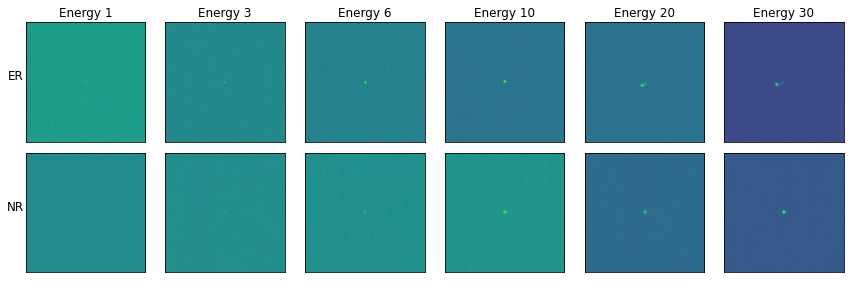

In [29]:
fig, axes = plt.subplots(2, 6, figsize=(6*2, 2*2))

for i, r_type in enumerate(['ER', 'NR']):
    for j, energy in enumerate([1, 3, 6, 10, 20, 30]):
        ax = axes[i, j]
        ids = [idx for idx, icls in enumerate(full_dataset.classes) if icls == (r_type, energy)]
        ax.imshow(full_dataset[random.choice(ids)][0])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

for r_type, ax in zip(['ER', 'NR'], axes[:, 0]):
    ax.set_ylabel(f'{r_type}', size='large', labelpad=10, rotation=0)

for energy, ax in zip([1, 3, 6, 10, 20, 30], axes[0, :]):
    ax.set_title(f'Energy {energy}', size='large')                         

fig.tight_layout()
fig.savefig('_assets/comb_classes.png', bbox_inches='tight', pad_inches=0)